In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
#import flamecounts_to_irradiance_converter as fcTirr 


In [ ]:

def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1)
    flame_min_wavelength = min(flame_data[:,0])
    flame_max_wavelength = max(flame_data[:,0])
    flame_lines = len(flame_data[:,0])
    k_min_wavelength = min(k_data[:,0])
    k_max_wavelength = max(k_data[:,0])
    k_lines = len(k_data[:,0])


    if k_min_wavelength == flame_min_wavelength and k_max_wavelength == flame_max_wavelength and flame_lines == k_lines:
        irradiance = np.zeros(flame_data.shape)
        for i in range(len(irradiance[:,0])):
            irradiance[i,0] = flame_data[i,0]
            irradiance[i,1] = flame_data[i,1]*k_data[i,1]/integration_time
        
        return k_data
    
    else:
        return print('ERROR. The length of flame data array and k data array are not the same!')   


In [14]:
#We first will start to load all the spectras in order to get the C matrix. 
current_path = os.getcwd()
txt_filenames = os.listdir(os.path.join(current_path,'Red Sweep Opening'))
print(txt_filenames)

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'c:\\Users\\UX490UA\\Documents\\GitHub\\SOLS-EQE\\Simulations EQE finder\\Red Sweep Opening'

0.41725121516526237
0.552015


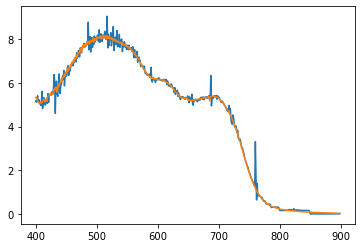

In [1023]:

#Now that we have all the data of the different pairs stored in Material_pairs we can start culating the EQE. As a first aproximation, we will say that the derivative of Jsc
#with respect to the cutting wavelength is equal to the EQE at the cutting wavelength multiplied by the solar irradiance at that wavelength. 

index_1 = 4
index_2 = 2
Active_layer_1 = Active_layers[index_1]
Jsc_divWL = np.array(Material_pairs[index_1][index_2].Jsc_Dividing_wavelength_graph_1)
Jsc_divWL_slope = np.gradient(np.array(Material_pairs[index_1][index_2].Jsc_Dividing_wavelength_graph_1), edge_order=1)
# for i in range(0,len(Jsc_divWL_slope)):
#     if 0 << i << len(Jsc_divWL_slope):
#         Jsc_divWL_slope[i] = (Jsc_divWL[i+1]-Jsc_divWL[i-1])/2
#     #else:
#     #    Jsc_divWL_slope[i] = 0

Solar_data_nparray = np.array(Solar_Data)
EQE_calculated = np.zeros((len(Jsc_divWL_slope)))
Jsc_calculated = np.zeros((len(Jsc_divWL_slope)))
Jsc_calculated_pernm = np.zeros((len(Jsc_divWL_slope)))
wl_list = np.array(Material_pairs[index_1][index_2].Dividing_wavelength_list)
for i in range(len(wl_list)):
    actual_wavelength = wl_list[i]
    Solar_Data_actualwl_index = np.where(Solar_data_nparray[:,0] == wl_list[i]) 
    EQE_calculated[i] = 100 * 1240/actual_wavelength * Jsc_divWL_slope[i]/Solar_data_nparray[Solar_Data_actualwl_index,1] * 1/(Active_layer_1.Integrated_Jsc_correction_factor)
    Jsc_calculated_pernm[i] = EQE_calculated[i] * Solar_data_nparray[Solar_Data_actualwl_index,1]

# for i in range(len(wl_list)):
#     for m in range(0,i+1):
#         Jsc_calculated[i] = Jsc_calculated[i]+Jsc_calculated_pernm[m]  
# Jsc_calculated_slope = np.gradient(Jsc_calculated)

#plt.plot(wl_list, Jsc_calculated/100 * Active_layer_1.Integrated_Jsc_correction_factor)#*Material_pairs[index_1][index_2].Jsc_Dividing_wavelength_graph_1[-1]/Jsc_calculated[-1])
#plt.plot(Material_pairs[index_1][index_2].Dividing_wavelength_list, Material_pairs[index_1][index_2].Jsc_Dividing_wavelength_graph_1)
plt.plot(wl_list, EQE_calculated)
#plt.plot(wl_list, Jsc_calculated_slope)
#plt.plot(wl_list, Jsc_divWL_slope*1000*Active_layer_1.Voc)
plt.plot(sf.Extract_Column(Active_layer_1.EQE_curve, 0), 1*np.array(sf.Extract_Column(Active_layer_1.EQE_curve, 1)))
#plt.plot(Solar_data_nparray[:,0], 10*Solar_data_nparray[:,1])
#plt.xlim(500,520)
#plt.ylim(1.1,1.5)
#plt.plot(wl_list,Jsc_calculated*Material_pairs[index_1][index_2].Jsc_Dividing_wavelength_graph_1[-1]/Jsc_calculated[-1]-Material_pairs[index_1][index_2].Jsc_Dividing_wavelength_graph_1)
plt.legend
plt.show

print(Active_layer_1.Integrated_Jsc_correction_factor)
print(Active_layer_1.Voc)



0.3327657966145502


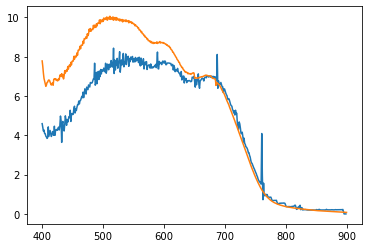

In [73]:
#Now that we have all the data of the different pairs stored in Material_pairs we can start culating the EQE. As a first aproximation, we will say that the derivative of Jsc
#with respect to the cutting wavelength is equal to the EQE at the cutting wavelength multiplied by the solar irradiance at that wavelength. 

index_1 = 2
index_2 = 3
Active_layer_2 = Active_layers[index_2]
Jsc_divWL_slope = np.gradient(np.array(Material_pairs[index_1][index_2].Jsc_Dividing_wavelength_graph_2))
Solar_data_nparray = np.array(Solar_Data)
EQE_calculated = np.zeros((len(Jsc_divWL_slope)))
wl_list = np.array(Material_pairs[index_1][index_2].Dividing_wavelength_list)
for i in range(len(wl_list)):
    actual_wavelength = wl_list[i]
    Solar_Data_actualwl_index = np.where(Solar_data_nparray[:,0] == wl_list[i]) 
    EQE_calculated[i] = -100 * 10 * Active_layer_2.Voc *  Jsc_divWL_slope[i]/Solar_data_nparray[Solar_Data_actualwl_index,1] #* 1/(Active_layer_2.Integrated_Jsc_correction_factor)


plt.plot(wl_list, EQE_calculated)
plt.plot(sf.Extract_Column(Active_layer_2.EQE_curve, 0), sf.Extract_Column(Active_layer_2.EQE_curve, 1))
#plt.xlim(300,400)
#plt.ylim(0,10)
plt.show
print(Active_layer_2.Integrated_Jsc_correction_factor)


In [10]:
print(Solar_data_nparray)

[[2.800e+02 2.540e-26]
 [2.805e+02 1.090e-24]
 [2.810e+02 6.130e-24]
 ...
 [3.990e+03 7.390e-03]
 [3.995e+03 7.230e-03]
 [4.000e+03 7.120e-03]]
